In [1]:
import os
import warnings
import sys

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

import mlflow
from mlflow.models import infer_signature
import mlflow.sklearn

import logging

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

In [3]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [4]:
def load_and_process_data():
    # Read the csv files
    data = pd.read_csv('data/application_record.csv')
    record = pd.read_csv('data/credit_record.csv')

    # find all users' account open month.
    begin_month=pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
    begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 

    new_data=pd.merge(data,begin_month,how="left",on="ID") #merge to record datatrain_raw_data.head()

    record['dep_value'] = None
    record.loc[record['STATUS'].isin(['2', '3', '4', '5']), 'dep_value'] = 'Yes'

    cpunt=record.groupby('ID').count()
    cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes' 
    cpunt['dep_value'][cpunt['dep_value'] == 0]='No' 
    cpunt = cpunt[['dep_value']]

    merge_data=pd.merge(new_data,cpunt,how='inner',on='ID')
    return merge_data

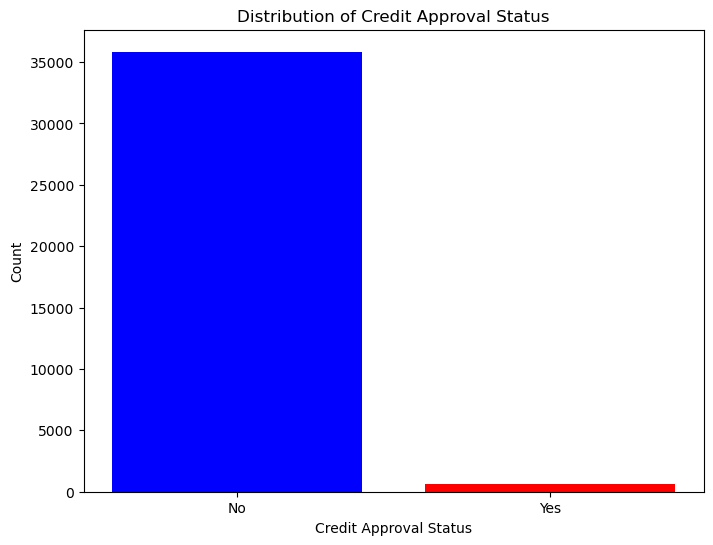

In [5]:
# Counts of each class in the target variable
merge_data = load_and_process_data()
class_counts = merge_data['dep_value'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values, color=['blue', 'red'])
plt.xlabel('Credit Approval Status')
plt.ylabel('Count')
plt.title('Distribution of Credit Approval Status')
plt.show()

In [9]:
merge_data = load_and_process_data()